# SEL635/SEL5724 - Visão Computacional Aplicada a Robótica



**Aluno:** Luiza Rodrigues Cardoso

**NUSP:** 14593332

Versão do documento: 1.1

# Lista 5 - Visão Estéreo - Parte B

O propósito deste exercício é implementar alguns dos métodos relacionados à visão estéreo.

## Preparação do ambiente e definição de funções de exercícios anteriores

In [1051]:
# Importar as bibliotecas que serão utilizadas
import numpy as np
import matplotlib.pyplot as plt
import math


## Funções básicas

Defina a seguir as funções implementadas em exercícios anteriores que serão utilizadas nessa Tarefa:

In [1052]:
def proj_perspectiva(Pc,f):
  (M,N) = np.shape(Pc) # recupera o tamanho da matriz (N linhas, M colunas)
  if(M!=3):
    print('Aviso: a matriz Pc usada como entrada não possui três linhas!')

  pc = np.zeros((3,N))  # Inicializa o vetor pc de dimensão 3xN com zeros
  
  # Encontra a projeção perspectiva dos pontos no plano da imagem em [mm]:
  ######
  # Coloque aqui o seu código para calcular a matriz pc
  #Obtendo as coordenadas do sistema em relação ao mundo
  Xc = Pc[0,:]
  Yc = Pc[1,:]
  Zc = Pc[2,:]

 

  #aplicando o fator de correção q
  x = f*Xc/Zc
  y = f*Yc/Zc
      
  #matriz no sistema de coordenas da camera
  pc[0,:] = x
  pc[1,:] = y
  pc[2,:] = 1 #coordenada homogenea

  ######

  return pc





In [1053]:
def camera_to_image(pc,sx,sy,ox,oy):
  (M,N) = np.shape(pc) # recupera o tamanho da matriz (N linhas, M colunas)
  if(M!=3):
    print('Aviso: a matriz pc usada como entrada não possui três linhas!')

  p_im = np.zeros((2,N))  # Inicializa o vetor p de dimensão 2xN com zeros

  # Converte as coordenadas dos pontos pc do sistema da câmera em [mm] para o sistema de coordenadas da imagem em [px]:
  #obtendo as coordenadas em relação ao sistema da camera
  x_im = pc[0,:]
  y_im = pc[1,:]
  
  #aplicando uma correção em relação à origem dos sistemas e passando da medida real(mm) para medidas discretas(pixel)
  x = ox - (x_im/sx)    
  y = oy - (y_im/sy)
      
  #matriz de coordenadas no sistema da imagem(x,y) em pixels
  p_im[0,:] = x
  p_im[1,:] = y 
    
  
  ######

  return p_im

In [1054]:
def calibration_pattern(n,d):
    Pw = np.zeros((3,3*n*n+7))
    Pw[:,0] = [0, 0, 0]
    Pw[:,1] = [n*d, 0, 0]
    Pw[:,2] = [0, n*d, 0]
    Pw[:,3]=[0, 0, n*d];
    Pw[:,4]=[n*d, n*d, 0];
    Pw[:,5]=[n*d, 0, n*d];
    Pw[:,6]=[0, n*d, n*d];

    for i in range(n):
        for j in range(n):
            Pw[:,n*i+j+7]= [d*j, d*i, 0]
            Pw[:,n*n + n*i+j+7]= [0, d*j, d*i];
            Pw[:,2*n*n + n*i+j+7]= [d*i, 0, d*j];

    return Pw

In [1055]:
def Rx(theta):
    theta = np.radians(theta)
    R = np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])
    return R
def Ry(theta):
    theta = np.radians(theta)
    R = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    return R
def Rz(theta):
    theta = np.radians(theta)
    R = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    return R
def Homogenea(R,t):
    t = t.reshape(-1, 1) #vetor de translação (formato de vetor coluna)
    H = np.concatenate((R,t),axis=1) #concatena na horizontal a matriz de rotação e vetor de translação
    temp_v = np.array([0,0,0,1]).reshape(1, -1) #ultima linha da matriz homogênia (formato de vetor linha)
    H = np.concatenate((H,temp_v),axis=0) #concatena na vertical a ultima linha da matriz de homografia
    return H

In [1056]:
def world_to_camera(Pw,Rwc,Twc):
    (M,N) = np.shape(Pw) # recupera o tamanho da matriz (M linhas, N colunas)

    # Coloque seu codigo aqui
    Pc = Rwc.T @ (Pw - Twc)

    return Pc


In [1057]:
def world_to_image(Pw,Rwc,Twc,f,sx,sy,ox,oy):

    # Coloque seu codigo aqui
    #passando as coord do mundo para a camera
    Pc = world_to_camera(Pw, Rwc, Twc)
    
    #aplicando projeção prespectiva
    pc = proj_perspectiva(Pc, f)

    #passando as coord da camera para a imagem
    p_im = camera_to_image(pc, sx, sy, ox, oy)

    return p_im


In [1058]:
def plot_image(p_im,size_x,size_y):
    plt.figure()
    plt.plot(p_im[0,4:],p_im[1,4:],'bo',mfc='none')
    plt.plot(p_im[0,0],p_im[1,0],'ko',mfc='none')
    plt.plot(p_im[0,1],p_im[1,1],'co',mfc='none')
    plt.plot(p_im[0,2],p_im[1,2],'ro',mfc='none')
    plt.plot(p_im[0,3],p_im[1,3],'go',mfc='none')
    plt.axis([0, size_x, size_y, 0])

In [1059]:
def calibrate_camera(Pw,p_im):
  (M,N) = np.shape(Pw)
    #montamdo a matriz A
  A = np.zeros((2*N, 12))

  #obtendo os vetores relacionadas as posições x,y,z no mundo e imagem
  Xw = Pw[0,:]
  Yw = Pw[1,:]
  Zw = Pw[2,:]

  Xim = p_im[0,:]
  Yim = p_im[1,:]
  
  #definindo A
  for i in range(N):
    
    X1 = Xw[i]
    Y1 = Yw[i]
    Z1 = Zw[i]
    x1 = Xim[i]
    y1 = Yim[i]
    #indice par - linha x
    k_x = 2*i
    #Indice impar - linha y
    k_y =  k_x+1
    
    A[k_x,:] = [ X1, Y1, Z1, 1, 0, 0, 0, 0, -x1*X1, -x1*Y1, -x1*Z1,-x1]
    A[k_y, :] = [ 0, 0, 0, 0,X1, Y1, Z1, 1, -y1*X1, -y1*Y1, -y1*Z1, -y1]
    
  #uso da biblio numpy pra calcular o SVD
  #retorno sao as matrizes U, S, Vh.T onde m será a coluna de Vt que contem os menores valores, i.e., a ultima linha
  U, S, Vt = np.linalg.svd(A, full_matrices=True, compute_uv=True, hermitian=False)
    
  m = Vt[-1,:] #matriz 4x3
  m_estim = m.reshape((3,4))
  #print("Matriz estimada: \n", m_estim)
  
  #calculo dos paramteros a partir dos vetores qi(3x1) que são os 3 primeiros elem da matriz estimada
  q1 = m_estim[0,0:3] # [m11, m12, m13]t
  q2 = m_estim[1,0:3] #[m21, m22, m23]t
  q3 = m_estim[2,0:3]# [m31, m32, m33]t
  q4 = m_estim[:,3] #[m14, m24, m34]t

  #normalizando os elems - fator de escala gama
  gama = np.linalg.norm(q3)
  
  q1_norm = q1 / gama
  q2_norm = q2 / gama
  q3_norm =  q3 / gama
  q4_norm  =  q4 / gama

  #centro optico
  ox = q1_norm.T @ q3_norm
  oy = q2_norm.T @ q3_norm

  #fatores extrinsecos
  #distancia focal
  
  fx = np.sqrt(max(0, (q1_norm.T@q1_norm) - (ox**2)))
  fy = np.sqrt(max(0,(q2_norm.T@q2_norm) - (oy**2)))
  
  #problema quando fy ou fx são muito pequenos
  if fx < 1e-6: fx = 1e-6
  if fy < 1e-6: fy = 1e-6

  Tz = q4_norm[2] # se positivo, em frente a camera,cc: atras dela
  if Tz >= 0:
    sigma = 1
  else:
    sigma = -1

  #calculando as linhas da matriz de rotação
  r1_i = sigma * (ox*q3_norm - q1_norm)/fx
  r2_i = sigma *( oy*q3_norm - q2_norm)/fy
  r3_i = sigma * q3_norm

  #matriz de translação
  Tx = (ox*Tz - q4_norm[0])/fx
  Ty = (oy*Tz - q4_norm[1])/fy

  #definindo a matriz de rotação
  R = np.vstack((r1_i, r2_i, r3_i)) #stack vertical

  # a matriz precisa ser ortonormal
  Ur, Dr, Vtr = np.linalg.svd(R)
  Rwc = (Ur @ Vtr)

  #analisando o det
  det =  np.linalg.det(Rwc)
  if det <0:
    Ur[:,2] = -Ur[:,2] #inverte o sinal pro det >0
    Rwc = (Ur @ Vtr)
    
  #definindo a translação
  Twc = np.vstack((Tx, Ty, Tz)).reshape(3,1)

  #verificando a posição dos pontos em relação a camera
  ponto1 = Pw[:, 0:1]
  Pcteste = Rwc @ ponto1 + Twc
  print("PONTO1",Pcteste)
  if Pcteste[2,0] < 0:# se a cordenada z for negativa
    Twc = -Twc #espelha a posição pro eixo positivo
    
  #Passando as coord camera-mundo
  Rcw = Rwc.T
  Tcw = -Rwc.T@Twc
  return Rcw,Tcw,fx,fy,ox,oy

In [1060]:
def skew_sym(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

In [1061]:
# Adiciona uma linha igual 1 a todos os elementos da matriz pim.
# Dessa forma as coordenadas dos pontos na imagem ficam sendo representadas como coordenadas homogêneas
def image_to_homogeneous(pim):
  ncol = pim.shape[1]
  row_of_ones = np.ones(ncol)
  pim_h = np.vstack([pim, row_of_ones])
  return pim_h

#### Imagens do Padrão de Calibração

Considere as duas câmeras e o padrão de calibração definidos e posicinados de acordo com as instruções da Tarefa 2.

Coloque a seguir a sequência de código utilizada ao final da Tarefa 2 para obter a imagem da câmera 1 e da câmera 2 do padrão de calibração.

Rwc1 =
 [[-0.71984631 -0.56524657 -0.40288658]
 [-0.26200263  0.75873967 -0.59637969]
 [ 0.64278761 -0.32374437 -0.69427204]]
Twc1 =
 [[1600]
 [1800]
 [1700]]
Valores Encontrados
PONTO1 [[ -530.61989421]
 [  -89.02853482]
 [-2898.36444277]]
A matriz de Rotação: 
 [[-0.71984631 -0.56524657 -0.40288658]
 [-0.26200263  0.75873967 -0.59637968]
 [ 0.64278761 -0.32374437 -0.69427204]]
A matriz posição: 
 [[1599.9999996 ]
 [1799.9999995 ]
 [1699.99999951]]
Distancias focais: fx=1199.999999540286 e fy=1199.9999996801494 em pixels e
 em mm fx=11.99999999540286 e fy=11.999999996801494
Distancia dos centros opticos: ox=799.999999822561 e oy=599.9999997534374
Rwc2 =
 [[-0.40957602 -0.63322265 -0.65671649]
 [-0.28678822  0.7727419  -0.56623536]
 [ 0.8660254  -0.04357787 -0.49809735]]
Twc2 =
 [[1700]
 [1500]
 [1600]]
PONTO1 [[-259.17908063]
 [ -12.90974113]
 [2762.72683073]]
Valores Encontrados
A matriz de Rotação: 
 [[-0.40957602 -0.63322265 -0.65671649]
 [-0.28678822  0.7727419  -0.56623536]
 [ 0.

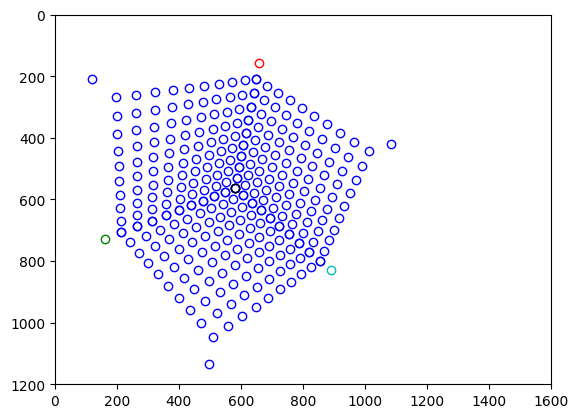

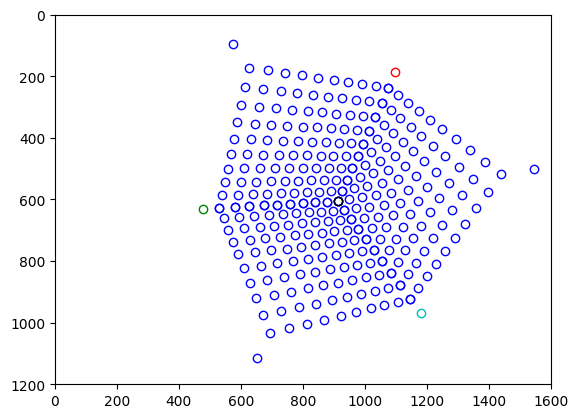

In [1062]:
## Coloque seu código aqui para fazer cada um dos passos a seguir

# Definir o padrão de calibração:
#Padrão de calibração
Pw = calibration_pattern(n=10, d=100)
f =12
sx = sy = 0.01
ox = 800
oy = 600


# Coloque seu código aqui para gerar a imagem obtida pela câmera 1:

# Definir a câmera 1:
#A camera 1 possui as seguintes rotações
r11 = Rz(20) #rotação de 20° em relação ao eixo z
r12 = Ry(-140) #rotação de -140° em relação ao eixo y
r13 = Rx(25) #rotação de 25° em relação ao eixo x

#matriz geral de rotação
Rwc1 = r11@r12@r13 
print('Rwc1 =\n',Rwc1)

#E sua posição é dado por:
Tw_c1 = (np.array([[1600, 1800, 1700]])).reshape(3,1)
print('Twc1 =\n',Tw_c1)
#Assim, temos que P_im será:
p_im1= world_to_image(Pw,Rwc1, Tw_c1, f, sx, sy, ox, oy)
#print('p_im1 = ',p_im1[:,0:6])


# TODO: Faça um print dos parâmetros intrínsecos e extrínsecos da camera 1
print("Valores Encontrados")
#Obtendo os parametros extrinsecos 
Rwc_est,Twc_est,fx_est,fy_est,ox_est,oy_est = calibrate_camera(Pw, p_im1)
print('A matriz de Rotação: \n', Rwc_est)
print('A matriz posição: \n', Twc_est)
print(f'Distancias focais: fx={fx_est} e fy={fy_est} em pixels e\n em mm fx={fx_est*sx} e fy={fy_est*sy}')
print(f'Distancia dos centros opticos: ox={ox_est} e oy={oy_est}')


# Obter a imagem do padrão de calibração a partir da câmera 1:
#a nova imagem obtida pelos paramteros estimados será:
p_m1_est = world_to_image(Pw, Rwc_est, Twc_est, fx_est*sx, sx, sy, ox_est, oy_est)
plot_image(p_m1_est, 1600, 1200)
# Coloque seu código aqui para gerar a imagem obtida pela câmera 2:

# Definir a câmera 2:
r21 = Rx(5) #rotação em relação ao eixo x, em relação a camera
r22 = Ry(-120) #rotação em relação ao eixo y, em relação ao mundo
r23 = Rz(35) #rotação em relação ao eixo z, em relação ao mundo

#No enunciado diz que as rotações em Z e y ocorrem em relação ao mundo e a rotação em X em relação a camera
#Assim, foi necessário aplicar as rotação relacionadas ao mundo antes dos eixos atuais
Rwc2 = r23 @ r22 @r21 
print('Rwc2 =\n',Rwc2)

Tw_c2 = (np.array([[1700,1500,1600]])).reshape(3,1)
print('Twc2 =\n',Tw_c2)

#Assim, temos que P_im será:
p_im2= world_to_image(Pw,Rwc2, Tw_c2, f, sx, sy, ox, oy)
#print('p_im1 = ',p_im1[:,0:6])

# TODO: Faça um print dos parâmetros intrínsecos e extrínsecos da camera 2
#Obtendo os parametros extrinsecos 
Rwc_est2,Twc_est2,fx_est2,fy_est2,ox_est2,oy_est2 = calibrate_camera(Pw, p_im2)
print("Valores Encontrados")
print('A matriz de Rotação: \n', Rwc_est2)
print('A matriz posição: \n', Twc_est2)
print(f'Distancias focais: fx={fx_est2} e fy={fy_est2} em pixels e\n em mm fx={fx_est*sx} e fy={fy_est*sy}')
print(f'Distancia dos centros opticos: ox={ox_est2} e oy={oy_est2}')

# Obter a imagem do padrão de calibração a partir da câmera 2:
#a nova imagem obtida pelos paramteros estimados será:
p_m2_est = world_to_image(Pw, Rwc_est2, Twc_est2, fx_est2*sx, sx, sy, ox_est2, oy_est2)
plot_image(p_m2_est, 1600, 1200)



## Parte A: Matriz Essencial, Fundamental e Reconstrução 3D

Na parte A, serão utilizados os parâmetros extrínsecos e intrínsecos conhecidos para cada uma das câmeras: $^{w}R_{c1}$, $^{w}t_{c1}$, $^{w}R_{c2}$, $^{w}t_{c2}$, $f_x$, $f_y$, $o_x$, $o_y$.

Considere que a câmera da esquerda do par estéreo é a câmera 1, e que a câmera da direita do par estéreo é a câmera 2.

Considere que as imagens de um padrão de calibração obtidas pela câmera 1 e câmera 2 foram fornecidas.

Considere que a correspondência entre os pontos de uma imagem com os pontos de outra imagem também é conhecida.

### Exercícios:

1. Obtenha a matriz essencial, $E$, a partir dos parâmetros extrínsecos fornecidos para cada câmera
:

In [1063]:
def essential_matrix(Rwc1,Twc1,Rwc2,Twc2):

    ## Implementar calculo da matriz essencial:
    #matriz que relaciona a orientação da camera c2 em relação a c1:
    
    Rcw1 = Rwc1.T
    R = Rcw1 @ Rwc2 #rtoacap de c1 em relacao a c1

    #encontrando o vetor de translação o1-o2 descrido no sistema de c1:
    t = (Rcw1  @ (Twc2 - Twc1)) #descrevendo no sistema de coord de c1
    
    #encontrando a matriz anti_simétria [t]x a partir da sua relação com o vetor translação
    t_x = skew_sym((t.reshape(-1)))

    #a matriz simetrica sera dada po:
    E = t_x @ R

    return E

Teste a função `essential_matrix` implementada para o par de câmeras 1 e 2:

In [1064]:
E = essential_matrix(Rwc1,Tw_c1,Rwc2,Tw_c2)
print(' E = ',E)
print('\n')
print('E_norm = ',E/E[2,2])
print('\n')


Pc1 = world_to_camera(Pw,Rwc1,Tw_c1)
Pc2 = world_to_camera(Pw,Rwc2,Tw_c2)

# Restrição epipolar para um dos pontos:
test = Pc1[:,1].T@E@Pc2[:,1]
print('Resultado da restrição epipolar para um ponto usando matriz fundamental:')
print(test)

 E =  [[ 122.20948641 -155.20611416 -260.0979196 ]
 [ 177.49733459   36.76649416  117.27625269]
 [ 248.66709046    1.4765014    69.83319781]]


E_norm =  [[ 1.75001991 -2.22252623 -3.72455978]
 [ 2.54173287  0.5264902   1.67937681]
 [ 3.56087217  0.02114326  1.        ]]


Resultado da restrição epipolar para um ponto usando matriz fundamental:
-5.960464477539063e-08


2. Obtenha a matriz fundamental, $F$, a partir dos parâmetros extrínsecos e intrínsecos fornecidos para cada câmera:

In [1065]:
def fundamental_matrix(Rwc1,Twc1,Rwc2,Twc2,fx,fy,ox,oy):
    E = essential_matrix(Rwc1,Twc1,Rwc2,Twc2)
    #E =  E / np.linalg.norm(E)
    K = np.array([[-fx, 0, ox], [0, -fy, oy], [0, 0, 1]])
    
    ## Implementar calculo da matriz fundamental:
    # K−T E K−1
    K_inv = np.linalg.inv(K)
    F = K_inv.T @ E @ K_inv

    return F

Teste a função `fundamental_matrix` implementada para o par de câmeras 1 e 2:

In [1066]:
fx = f/sx
fy = f/sy
F = fundamental_matrix(Rwc1,Tw_c1,Rwc2,Tw_c2,fx,fy,ox,oy)
print(' F = ',F)
print('\n')
print(' F_NORM = ',F/F[2,2])
print('\n')

# Converte as coordenadas dos pontos na imagem para coordenadas homogêneas:
p_im1h = image_to_homogeneous(p_im1)
p_im2h = image_to_homogeneous(p_im2)

# Restrição epipolar para um dos pontos:
test = p_im1h[:,0].T@F@p_im2h[:,0]
print('Resultado da restrição epipolar para um ponto usando matriz fundamental:')
print(test)

 F =  [[ 8.48676989e-05 -1.07782024e-04  2.13523321e-01]
 [ 1.23262038e-04  2.55322876e-05 -2.11659213e-01]
 [-3.49073957e-01  6.96758286e-02  1.92526380e+02]]


 F_NORM =  [[ 4.40810755e-07 -5.59829899e-07  1.10906008e-03]
 [ 6.40234539e-07  1.32617087e-07 -1.09937773e-03]
 [-1.81312274e-03  3.61902762e-04  1.00000000e+00]]


Resultado da restrição epipolar para um ponto usando matriz fundamental:
2.842170943040401e-14


3. Implemente uma função para obter a reconstrução 3D de pontos a partir das  coordenadas na imagem destes pontos obtidas pela câmera 1 e pela câmera 2. A coordenda 3D reconstruída deve ser obtida em relação ao sistema de coordenadas da câmera 1 (esquerda).

In [1067]:
def reconstruction_3D(p_im1,p_im2,Rwc1,Twc1,Rwc2,Twc2,fx,fy,ox,oy):
    # Implementar um dos métodos de reconstrução 3D
    #Sendo K a matriz de paramteros intrisecos
    K = np.array([[-fx, 0, ox], [0, -fy, oy], [0, 0, 1]])
    
    
    zeros = np.zeros((3,1))

    #entao M sera M= [K 0]
    M1 = np.hstack([K, zeros])

    #rotação de c2 em relaçao a c1
    Rcw1 = Rwc1.T
    R = (Rcw1) @ Rwc2

    #encontrando o vetor de translação o1-o2 descrido no sistema de c1:
    t_w1w2 = Twc2 - Twc1
    t = ((Rcw1)  @ t_w1w2) #descrevendo no sistema de coord de c1

    #dimensao (3, 4) eg dim(M1)
    M2 = np.hstack([K @ R, K @ t])

    p_im1H = image_to_homogeneous(p_im1)
    p_im2H = image_to_homogeneous(p_im2)

    N_ptos = p_im1H.shape[1]
    P_reconst = np.zeros((3, N_ptos))
    
    for idx in range(N_ptos):
        p1 = (p_im1H[:, idx])
        p2 = (p_im2H[:, idx])
        p1_x = skew_sym(p1)
        p2_x = skew_sym(p2)

        #cada elem de matrix é o prod escalar 
        m01 = p1_x @ M1 #(3, 4)
        m02 = p2_x @ M2 #(3, 4)
        
        #construindo a matrix composto por m01 e m02
        matrix = np.vstack((m01, m02)) #(6, 4)
        
        #encontrando p por mq -> Matrix @ P = 0
        U, s, Vt = np.linalg.svd(matrix)
        P = Vt[-1,:] #será a ultima linha
        P_3d = P[:3] / P[3]
        P_reconst[:, idx] = P_3d
    
    return P_reconst

4. Compare a reconstrução 3D dos 7 primeiros pontos do padrão de calibração com as coordenadas 3D verdadeiras destes pontos. Para comparar, encontre o módulo da distância Euclidiana entre cada um dos pontos.

In [1068]:
fx = f/sx
fy = f/sy

E = essential_matrix(Rwc1,Tw_c1,Rwc2,Tw_c2)
print("E: ", E)

F = fundamental_matrix(Rwc1,Tw_c1,Rwc2,Tw_c2,fx,fy,ox,oy)
print("F: ", F)

Pc1_reconst = reconstruction_3D(p_im1,p_im2,Rwc1,Tw_c1,Rwc2,Tw_c2,fx,fy,ox,oy) # em coord homog
print("Pc1_reconst: ",(Pc1_reconst))

# Calcular a distância Euclidiana entre Pc1_reconst e Pc1 dos 7 primeiros pontos::
# <completar_codigo>
#o vetor que obtemos estava normalizado entao precisado passar ele pra coordenadas reais no sistema de c1
#7 pontos de interesse
Pc1_7ptos = Pc1[:, :7] 
dist = []
for i in range(7):
    dist.append(np.linalg.norm(Pc1_7ptos[:, i] - Pc1_reconst[:, i] ))
    print(f'Ponto {i} - distancia = {dist[i]}') #printando os valores da disntancia euclideana para cada ponto


E:  [[ 122.20948641 -155.20611416 -260.0979196 ]
 [ 177.49733459   36.76649416  117.27625269]
 [ 248.66709046    1.4765014    69.83319781]]
F:  [[ 8.48676989e-05 -1.07782024e-04  2.13523321e-01]
 [ 1.23262038e-04  2.55322876e-05 -2.11659213e-01]
 [-3.49073957e-01  6.96758286e-02  1.92526380e+02]]
Pc1_reconst:  [[ 8.80287444e+01  8.70764448e+02 -1.94632864e+03  3.33979397e+01
  -4.03805288e+03  3.71190709e+01 -4.82022306e+02  8.80287444e+01
   1.09694876e+02  1.34226971e+02  1.62621959e+02  1.96331324e+02
   2.37561716e+02  2.89849153e+02  3.59249590e+02  4.57086245e+02
   6.07290871e+02  1.06082739e+02  1.31246769e+02  1.59769843e+02
   1.92834890e+02  2.32170177e+02  2.80414492e+02  3.41819649e+02
   4.23720259e+02  5.39966399e+02  7.20253850e+02  1.30243743e+02
   1.59763115e+02  1.93277791e+02  2.32218465e+02  2.78685340e+02
   3.35904569e+02  4.09115081e+02  5.07447911e+02  6.48391622e+02
   8.70231917e+02  1.63574274e+02  1.98660854e+02  2.38591996e+02
   2.85142892e+02  3.4093603

## Parte B: Estimar matriz Fundamental e Essencial pelo método dos 8 pontos, reconstrução 3D

Na parte B, considere apenas que os parâmetros intrínsecos são conhecidos: $f_x$, $f_y$, $o_x$, $o_y$.

Considere que a câmera da esquerda do par estéreo é a câmera 1, e que a câmera da direita do par estéreo é a câmera 2.

Considere que as imagens de um padrão de calibração obtidas pela câmera 1 e câmera 2 foram fornecidas.

Considere que a correspondência entre os pontos de uma imagem com os pontos de outra imagem também é conhecida.

### Exercícios:

1. Obtenha a matriz fundamental, $F$, pelo método dos 8 pontos:

In [1069]:
def estimate_fundamental_matrix(p_im1,p_im2):
    ## Implementar a estimativa da matriz fundamental, normalize a matriz usando Fest[2,2]
    N=  p_im1.shape[1]
    matrix_U = np.zeros((N,9))
    F = np.array(9)

    for j in range(N):
        #ptos referentes a cm1
        x1 = p_im1[0, j]
        y1 = p_im1[1, j]

        #ptos referentes a cm2
        x2 = p_im2[0, j]
        y2 = p_im2[1,j]
        
        matrix_U[j,:] = [x1*x2, x1*y2,x1,  y1*x2, y1*y2, y1, x2, y2, 1]

    #aplicando o svd
    U, D, V = np.linalg.svd(matrix_U, full_matrices=True, compute_uv=True, hermitian=False)
    F = V[-1,:]
    F_est = F.reshape(3,3)

    #normalizando a matriz estimada
    F_est = F_est/F_est[2,2]

    return F_est

In [1070]:
F_est = estimate_fundamental_matrix(p_im1,p_im2)

print(' F_est = ',F_est)

# Restrição epipolar para um dos pontos:
test = p_im1h[:,0].T@F_est@p_im2h[:,0]
print('Resultado da restrição epipolar para um ponto usando matriz fundamental estimada:')
print(test)

 F_est =  [[ 4.40810755e-07 -5.59829899e-07  1.10906008e-03]
 [ 6.40234539e-07  1.32617087e-07 -1.09937773e-03]
 [-1.81312274e-03  3.61902762e-04  1.00000000e+00]]
Resultado da restrição epipolar para um ponto usando matriz fundamental estimada:
6.661338147750939e-15


2. A partir da matriz fundamental obtida pelo método dos 8 pontos e dos parâmetros intrínsecos, estimar matriz essencial, $E$:

In [1071]:
def estimate_essential_matrix(F_est,fx,fy,ox,oy):
    ## Implementar a estimativa da matriz essencial, normalize a matriz usando E_est[2,2]
    K = np.array([[-fx, 0, ox], 
                  [0, -fy, oy], 
                  [0, 0, 1]])
    
    #a matriz e com ruido é dado pela relação
    matrix_E = K.T @ F_est @ K

    #aplicando o svd
    U, D, V = np.linalg.svd(matrix_E, full_matrices=True, compute_uv=True, hermitian=False)
    Diag = np.diag((1, 1, 0))
    E_est = U @ Diag @ V #a melhor estimativa de e

    #normalizando E
    E_est = E_est/E_est[2,2]
    return E_est

In [1072]:
E_est = estimate_essential_matrix(F_est,fx,fy,ox,oy)

print(E_est)

# Restrição epipolar para um dos pontos:
test = Pc1[:,1].T@E@Pc2[:,1]
print('Resultado da restrição epipolar para um ponto usando matriz essencial estimada:')
print(test)

[[ 1.75001991 -2.22252623 -3.72455978]
 [ 2.54173287  0.5264902   1.67937681]
 [ 3.56087217  0.02114326  1.        ]]
Resultado da restrição epipolar para um ponto usando matriz essencial estimada:
-5.960464477539063e-08


4. Obtenha a reconstrução 3D (a menos de um fator de escala), em relação ao sistema de coordenadas da câmera 1, dos 7 primeiros pontos do padrão de calibração a partir das imagens da câmera 1 e câmera 2:

##### Metodo que deu errado


def estimate_reconstruct_3d(F_est, p_im1, p_im2, fx, fy, ox, oy, sx, sy):
    # Implementar um dos métodos de reconstrução 3D
    f = fx * sx
    K = np.array([[-fx, 0, ox],
                  [0, -fy, oy],
                  [0, 0, 1]])

    # a matriz E com ruido é dada pela relação
    matrix_E = K.T @ F_est @ K

    # aplicando o SVD
    U, D, Vt = np.linalg.svd(matrix_E)
    # força E a ter dois valores singulares iguais e um zero
    Diag = np.diag([1, 1, 0])
    E_limpa = U @ Diag @ Vt

    # normalização de E
    traco = np.trace(E_limpa @ E_limpa.T)
    fator_N = np.sqrt(traco / 2)
    E_norm = E_limpa / fator_N

    # cálculo de E * E^T
    E_ET = E_norm @ E_norm.T

    # obtendo tx, ty, tz
    tx_mag = np.sqrt(max(0, 1 - E_ET[0, 0]))
    ty_mag = np.sqrt(max(0, 1 - E_ET[1, 1]))
    tz_mag = np.sqrt(max(0, 1 - E_ET[2, 2]))

    # outros elementos de E_ET
    neg_txty = E_ET[0, 1]
    neg_txtz = E_ET[0, 2]
    neg_tytz = E_ET[1, 2]

    # assumindo que Tx é positivo
    tx = tx_mag
    ty = -neg_txty / tx_mag if tx_mag != 0 else 0
    tz = -neg_txtz / tx_mag if tx_mag != 0 else 0

    t_1 = np.array([tx, ty, tz])
    t_2 = -t_1

    # estimando a rotação
    wi = np.zeros((3, 3))
    for i in range(3):
        wi[:, i] = np.cross(E_norm[:, i], t_1)

    r1 = wi[:, 0] + np.cross(wi[:, 1], wi[:, 2])
    r2 = wi[:, 1] + np.cross(wi[:, 2], wi[:, 0])
    r3 = wi[:, 2] + np.cross(wi[:, 0], wi[:, 1])

    R = np.column_stack((r1, r2, r3))

    # garante que R seja uma matriz de rotação válida
    U_R, _, Vt_R = np.linalg.svd(R)
    R = U_R @ Vt_R
    if np.linalg.det(R) < 0:
        R *= -1

    # verificando os sinais
    p1 = p_im1[:, 0]
    p2 = p_im2[:, 0]

    x2 = (ox - p_im2[0, 0]) * sx  # em mm
    r1_T = R[:, 0]
    r3_T = R[:, 2]

    # montando p = (x, y, f).T
    x1 = (ox - p1[0]) * sx
    y1 = (oy - p1[1]) * sy
    p = np.array([x1, y1, f])

    # equacionando Z
    possib = [(R, t_1), (R, t_2)]
    R_correto, T_correto = None, None
    for r_tst, t_tst in possib:
        aux = (f * r1_T) - (x2 * r3_T)
        denom = (aux @ p)
        if abs(denom) < 1e-10:
            continue  # evita divisão por zero

        Z = f * (aux @ t_tst) / denom

        # ponto 3D
        P = (Z / f) * p

        # profundidade
        z_linha = r3_T @ (P - t_tst)

        # teste de profundidade positiva
        if Z > 0 and z_linha > 0:
            R_correto = r_tst
            T_correto = t_tst
            break

    if R_correto is None:
        print("Há um problema grave na estimação de E ou F")
        return None

    m1 = np.hstack([K, np.zeros((3, 1))])
    m2 = np.hstack([K @ R_correto, K @ T_correto.reshape(3, 1)])

    p_im1H = image_to_homogeneous(p_im1)
    p_im2H = image_to_homogeneous(p_im2)

    N_ptos = p_im1H.shape[1]
    P_reconst_est = np.zeros((3, N_ptos))

    for idx in range(N_ptos):
        p1 = p_im1H[:, idx]
        p2 = p_im2H[:, idx]
        p1_x = skew_sym(p1)
        p2_x = skew_sym(p2)

        m01 = p1_x @ m1
        m02 = p2_x @ m2

        matrix = np.vstack((m01, m02))
        U, s, Vt = np.linalg.svd(matrix)
        P = Vt[-1, :]
        if P[3] == 0:
            continue
        P_3d = P[:3] / P[3]
        P_reconst_est[:, idx] = P_3d

    return P_reconst_est


### Metodo Correto

In [1078]:
def estimate_reconstruct_3d(F_est, p_im1, p_im2, fx, fy, ox, oy, sx, sy):
    # Implementar um dos métodos de reconstrução 3D
    f = fx * sx # valor em mm
    K = np.array([[-fx, 0, ox],
                  [0, -fy, oy],
                  [0, 0, 1]])

    # a matriz E com ruido é dada pela relação
    matrix_E = K.T @ F_est @ K

    # aplicando o SVD
    U, D, Vt = np.linalg.svd(matrix_E)
    # força E a ter dois valores singulares iguais e um zero
    Diag = np.diag([1, 1, 0])
    E_limpa = U @ Diag @ Vt

    t_1 = U[:, 2]
    t_2 = -U[:, 2]
    

    # estimando a rotação
    wi = np.zeros((3, 3))
    for i in range(3):
        wi[:, i] = np.cross(E_limpa[:, i], t_1)

    r1 = wi[:, 0] + np.cross(wi[:, 1], wi[:, 2])
    r2 = wi[:, 1] + np.cross(wi[:, 2], wi[:, 0])
    r3 = wi[:, 2] + np.cross(wi[:, 0], wi[:, 1])

    #matriz de rotacao
    R = np.column_stack((r1, r2, r3))
    U_r, _, Vt_r = np.linalg.svd(R) #garante ortogonalidade
    R = U_r @ Vt_r
    if np.linalg.det(R) < 0:
        R *= -1

    # verificando os sinais a partir de pontos da img
    p1 = p_im1[:, 0]
    p2 = p_im2[:, 0]

    
    r1_T = R[:, 0]
    r3_T = R[:, 2]

    # montando p = (x, y, f).T
    x2 = (ox - p2[0]) * sx  # em mm
    x1 = (ox - p1[0]) * sx
    y1 = (oy - p1[1]) * sy

    p = np.array([x1, y1, f]) #pto na img

    # equacionando Z
    possib = [(R, t_1), (R, t_2)]
    R_correto, T_correto = None, None
    for r_tst, t_tst in possib:
        aux = (f * r1_T) - (x2 * r3_T)
        denom = (aux @ p)
        if abs(denom) < 1e-10:
            continue  # evita divisão por zero

        Z = f * (aux @ t_tst) / denom

        # ponto 3D
        P = (Z / f) * p

        # profundidade
        z_linha = r3_T @ (P - t_tst)

        # teste de profundidade positiva
        if Z > 0 and z_linha > 0:
            R_correto = r_tst
            T_correto = t_tst
            break

    if R_correto is None:
        print("Há um problema grave na estimação de E ou F")
        return None

    m1 = np.hstack([K, np.zeros((3, 1))])
    m2 = np.hstack([K @ R_correto, K @ T_correto.reshape(3, 1)])

    p_im1H = image_to_homogeneous(p_im1)
    p_im2H = image_to_homogeneous(p_im2)

    N_ptos = p_im1H.shape[1]
    P_reconst_est = np.zeros((3, N_ptos))

    for idx in range(N_ptos):
        p1 = p_im1H[:, idx]
        p2 = p_im2H[:, idx]
        p1_x = skew_sym(p1)
        p2_x = skew_sym(p2)

        m01 = p1_x @ m1
        m02 = p2_x @ m2

        matrix = np.vstack((m01, m02))
        U, s, Vt = np.linalg.svd(matrix)
        P = Vt[-1, :]
        if P[3] == 0:
            continue
        P_3d = P[:3] / P[3]
        P_reconst_est[:, idx] = P_3d

    return P_reconst_est


In [1074]:
Pw_reconst_est = estimate_reconstruct_3d(F_est,p_im1, p_im2,fx,fy,ox,oy, sx, sy)
print('Reconstrução 3D dos pontos (estimada a menos de fator de escala):')
print(Pw_reconst_est)

Reconstrução 3D dos pontos (estimada a menos de fator de escala):
[[ 2.48986019e-01  2.54240451e+00 -5.87433216e+00 -2.73672267e-03
  -1.21589088e+01  4.89742220e-02 -8.57445066e-01  2.48986019e-01
   3.11387664e-01  3.82452912e-01  4.65081084e-01  5.63507058e-01
   6.84182675e-01  8.37460731e-01  1.04108691e+00  1.32825817e+00
   1.76915635e+00  3.05689968e-01  3.78537445e-01  4.61529391e-01
   5.58127358e-01  6.73400411e-01  8.15100352e-01  9.95730312e-01
   1.23687289e+00  1.57929891e+00  2.11044400e+00  3.80572438e-01
   4.66507945e-01  5.64487441e-01  6.78722106e-01  8.15402509e-01
   9.84047563e-01  1.20012550e+00  1.49060823e+00  1.90716912e+00
   2.56294896e+00  4.82778693e-01  5.85526774e-01  7.02845469e-01
   8.39988137e-01  1.00472008e+00  1.20907519e+00  1.47281648e+00
   1.83090271e+00  2.35166831e+00  3.18929099e+00  6.28678210e-01
   7.53716420e-01  8.96854543e-01  1.06487748e+00  1.26789286e+00
   1.52173944e+00  1.85282445e+00  2.30883105e+00  2.98572062e+00
   4.10980

5. Calcule o vetor tridimensional $V_a$ como sendo a média das coordenadas 3D estimadas na Tarefa 4, Parte A.3, então calcule sua normal: $||V_a|| = \sqrt{V_{ax}^2 + V_{ay}^2 + V_{az}^2}$. Normalize as coordenadas 3D estimadas na Parte A.3 pelo fator $||V_a||$.

In [1075]:
# Coloque o código aqui
Pc1_reconst = reconstruction_3D(p_im1,p_im2,Rwc1,Tw_c1,Rwc2,Tw_c2,fx,fy,ox,oy) 
Pontos_3d = Pc1_reconst[:, :7]

x_md =  np.mean(Pontos_3d[0, :])
y_md = np.mean(Pontos_3d[1, :])
z_md = np.mean(Pontos_3d[2, :])
#vetor medio
Va = np.array([x_md, y_md, z_md])
print("Va: ", Va)
Va_norm = np.linalg.norm(Va)
print("Fator de normalização: ", Va_norm)

#normalzaindo os pontos 3d
Ptos_norms =  Pontos_3d/Va_norm
print("Os pontos 3D normalizados sao: ", Ptos_norms)

Va:  [-776.72765946  533.9773994  1289.97542907]
Fator de normalização:  1597.6464964639881
Os pontos 3D normalizados sao:  [[ 0.05509901  0.54502949 -1.21824737  0.02090446 -2.52750085  0.02323359
  -0.30170774]
 [ 0.13190361  0.69505218  1.35088899  0.16084421 -0.08443547  0.18338698
  -0.09804797]
 [-0.53378184 -1.56255734  4.82669559 -0.02645881  3.72234827 -0.12830692
  -0.64598276]]


6. Calcule o vetor tridimensional $V_b$ como sendo a média das coordenadas 3D estimadas na Tarefa 5, Parte B.4, então calcule sua normal: $||V_b|| = \sqrt{V_{bx}^2 + V_{by}^2 + V_{bz}^2}$. Normalize as coordenadas 3D estimadas na Parte B.4 pelo fator $||V_b||$.

In [1076]:
# Coloque o código aqui
F_est = estimate_fundamental_matrix(p_im1,p_im2)
P2_reconst =  estimate_reconstruct_3d(F_est, p_im1,p_im2,fx,fy,ox,oy, sx, sy) 
Ptos_3d_2 = P2_reconst[:, :7]

x2_md =  np.mean(Ptos_3d_2[0, :])
y2_md = np.mean(Ptos_3d_2[1, :])
z2_md = np.mean(Ptos_3d_2[2, :])
#vetor medio
Vb = np.array([x2_md, y2_md, z2_md])
print("Vb: ", Vb)
Vb_norm = np.linalg.norm(Vb)
print("Fator de normalização: ", Vb_norm)

#normalzaindo os pontos 3d
Ptos_norms2 =  Ptos_3d_2/Vb_norm
print("Os pontos 3D normalizados sao: ", Ptos_norms2)

Vb:  [-2.29329399  1.56765681  4.04284755]
Fator de normalização:  4.905238175908629
Os pontos 3D normalizados sao:  [[ 5.07592108e-02  5.18303989e-01 -1.19756309e+00 -5.57918406e-04
  -2.47876012e+00  9.98406606e-03 -1.74801923e-01]
 [ 1.26153286e-01  6.63345634e-01  1.32469144e+00  1.03522665e-01
  -8.43153087e-02  1.04966578e-01 -1.24608402e-03]
 [-5.23307739e-01 -1.50568494e+00  4.73516171e+00 -4.22336140e-02
   3.64430941e+00 -8.08549812e-02 -4.58060845e-01]]


7. Compare as coordenadas normalizadas obtidas no item B.5 com as coordenadas obtidas no item B.6. Utilize a distância Euclidiana entre cada ponto para verificar a diferença entre os dois métodos de reconstrução.

In [1077]:
# Coloque o código aqui
dist_2 = []
for i in range(7):
    dist_2.append(np.linalg.norm(Ptos_norms[:, i] - Ptos_norms2[:, i]))
    print(f'Ponto {i+1} - distancia = {dist_2[i]}') 

Ponto 1 - distancia = 0.012712465166768779
Ponto 2 - distancia = 0.0703848511312375
Ponto 3 - distancia = 0.09742998361537081
Ponto 4 - distancia = 0.06320789410484326
Ponto 5 - distancia = 0.09200943837323955
Ponto 6 - distancia = 0.09261206842076039
Ponto 7 - distancia = 0.24655696837415003


## Revisão da Parte Teórica

* **Matriz Essencial:**  


$E = S({^l\mathbf{T}}) {^lR_r}$

onde ${^l\mathbf{T}}$ é o vetor que representa a posição da origem da câmera da direita em relação à origem da câmera esquerda, descrito no sistema de coordenadas da câmera da esquerda. ${^lR_r}$ é a orientação da câmera da direita em relação à esquerda.

Para ${^l\mathbf{T}} = [T_x, T_y, T_z]^T$:
\begin{align*}
S({^l\mathbf{T}}) = \begin{bmatrix} -0 &-T_z & T_y \\ T_z &0 &-T_x \\ -T_y &T_x &0 \end{bmatrix}
\end{align*}

Para verificar se a matriz essencial está correta: $\mathbf{P}_l^T E \mathbf{P}_r = 0$

onde $\mathbf{P}_r$ é a coordenada de um ponto 3D descrito no sistema de coordenadas da câmera da direita, e $\mathbf{P}_l$ é a coordenada do mesmo ponto 3D descrito no sistema de coordenadas da câmera da esquerda.

A verificação também pode ser feita utilizando $\mathbf{p}_l^T E \mathbf{p}_r = 0$ para:

$\mathbf{p}_l = \frac{1}{Z_l}\mathbf{P}_l$

$\mathbf{p}_r = \frac{1}{Z_r}\mathbf{P}_r$

ou seja, o ponto $\mathbf{p}$ é a projeção perspectiva de $\mathbf{P}$ em um plano de projeção normalizado (considerando $f=1$).

* **Matriz Fundamental:** $ F = (K_l^{-1})^T E K_r^{-1}$


onde considerou-se a matriz intrínseca:
\begin{align*}
K = \begin{bmatrix} -f/s_x & 0 & o_x \\ 0 & -f/s_y & o_y \\ 0 & 0 &1 \end{bmatrix}
\end{align*}

Observe que para a matriz intrínseca anterior, $\overline{\mathbf{p}} = K \mathbf{p}$, onde $\overline{ \mathbf{p}}$ são as coordenadas em pixel de um ponto no sistema de coordenadas da imagem, e $\mathbf{p}$ são as coordenadas métricas do ponto em um plano de projeção normalizado (com distância focal $f=1$) no sistema de coordenadas da câmera.

Para verificar a matriz fundamental, fazer: $\overline{\mathbf{p}}_l^T F \overline{\mathbf{p}}_r = 0$

## Algumas das Respostas Esperadas

Considerando a câmera 1 como a câmera da esquerda, e a câmera 2 como a câmera da direita:

Matriz Essencial:
```
E =  [[ 122.20948641 -155.20611416 -260.0979196 ]
 [ 177.49733459   36.76649416  117.27625269]
 [ 248.66709046    1.4765014    69.83319781]
```

Matriz Essencial normalizada pelo elemento da linha 3 coluna 3:
```
E =  [[ 1.75001991 -2.22252623 -3.72455978]
 [ 2.54173287  0.5264902   1.67937681]
 [ 3.56087217  0.02114326  1.        ]
 ```


Matriz Fundamental:
```
F =  [[ 8.48676989e-05 -1.07782024e-04  2.13523321e-01]
 [ 1.23262038e-04  2.55322876e-05 -2.11659213e-01]
 [-3.49073957e-01  6.96758286e-02  1.92526380e+02]]
```

Matriz Fundamental normalizada pelo elemento da linha 3 coluna 3:
```
 F =  [[ 4.40810755e-07 -5.59829899e-07  1.10906008e-03]
 [ 6.40234539e-07  1.32617087e-07 -1.09937773e-03]
 [-1.81312274e-03  3.61902762e-04  1.00000000e+00]
 ```